In [1]:
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam
from keras.datasets import mnist
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

import sys

from core.data_selector import DataSelector

import matplotlib.pyplot as plt
import random

In [2]:
# Fijar semillas
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# 1. Data set MNIST

In [3]:
# Cargar el dataset MNIST
(X_train, y_train), (X_val, y_val) = mnist.load_data()

# Normalizar los valores de píxeles al rango [0, 1]
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

# Aplanar las imágenes para que sean vectores unidimensionales
X_train = X_train[..., tf.newaxis]
X_val = X_val[..., tf.newaxis]

# Codificar las etiquetas utilizando OneHotEncoder
enc = OneHotEncoder(sparse_output=False)
y_train_encoded = enc.fit_transform(y_train.reshape(-1, 1))
y_val_encoded = enc.transform(y_val.reshape(-1, 1))

# Selección de datos de entrenamiento y validación
num_samples_train = 10000
num_samples_val = int(num_samples_train / 6)

# Generar índices aleatorios para el conjunto de entrenamiento
random_indices_train = np.random.choice(len(X_train), size= num_samples_train, replace=False)

# Generar índices aleatorios para el conjunto de validación
random_indices_val = np.random.choice(len(X_val), size=num_samples_val, replace=False)

X_train = X_train[random_indices_train]
y_train_encoded = y_train_encoded[random_indices_train]

X_val = X_val[random_indices_val]
y_val_encoded = y_val_encoded[random_indices_val]

print(f'Size training set: {X_train.shape}')
print(f'Size Val set: {X_val.shape}')

Size training set: (10000, 28, 28, 1)
Size Val set: (1666, 28, 28, 1)


## 2. Model

In [4]:
class CustomModel(tf.keras.Model):
    def __init__(self):
        super(CustomModel, self).__init__()
        # Primera capa convolucional
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))
        # Capa de MaxPooling
        self.maxpool_1 = tf.keras.layers.MaxPooling2D((2, 2))#
        # Segunda capa convolucional
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        # Capa de MaxPooling
        self.maxpool_2 = tf.keras.layers.MaxPooling2D((2, 2))#
        # Capa para aplanar el output de las convoluciones
        self.flatten = tf.keras.layers.Flatten()
        # Capa densa
        self.fc1 = tf.keras.layers.Dense(128, activation='relu')
        # Capa de salida
        self.fc2 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool_1(x)
        x = self.conv2(x)
        x = self.maxpool_2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    def inspector_out(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool_1(x)
        x = self.conv2(x)
        x = self.maxpool_2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [5]:
# Instanciar el modelo
model_mnist = CustomModel()

## 3. Primera fase de entrenamiento: sin Filtrado

In [6]:
# Configuración del entrenamiento
learning_rate = 0.001
adam_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
model_mnist.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Configuración del Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy',      # Monitorea el accuracy de validación
                               patience=20,                 # Número de épocas sin mejora después de las cuales el entrenamiento será detenido
                               verbose=1,                   # Muestra mensajes al detener
                               mode='max',                  # Detiene el entrenamiento cuando el valor monitoreado deja de aumentar
                               restore_best_weights=True)   # Restaura los pesos del modelo al mejor valor encontrado

In [7]:
# Entrenamiento
model_mnist.fit(X_train, y_train_encoded, epochs=3000, batch_size=3000, verbose = 0, validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

Restoring model weights from the end of the best epoch: 48.
Epoch 68: early stopping


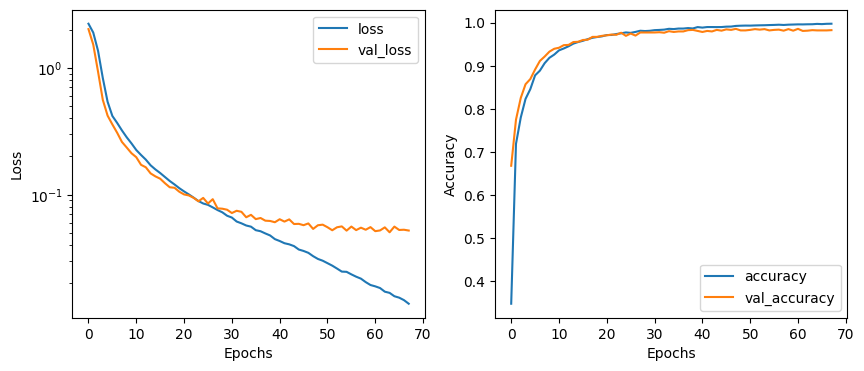

In [8]:
# Resultados
plt.figure(figsize=(10, 4))

# Gráfica Loss
plt.subplot(1, 2, 1)
plt.plot(model_mnist.history.history['loss'], label='loss')
plt.plot(model_mnist.history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

# Gráfica Accuracy
plt.subplot(1, 2, 2)
plt.plot(model_mnist.history.history['accuracy'], label='accuracy')
plt.plot(model_mnist.history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [9]:
# Evalaución para los mejores pesos para el modelo
loss_train, accuracy_train = model_mnist.evaluate(X_train, y_train_encoded, verbose=0)
loss_val, accuracy_val = model_mnist.evaluate(X_val, y_val_encoded, verbose=0)
print(f"Train loss: {loss_train}")
print(f"Train accuracy: {accuracy_train}")
print(f"Validation loss: {loss_val}")
print(f"Validation accuracy: {accuracy_val}")

Train loss: 0.03112589381635189
Train accuracy: 0.9926000237464905
Validation loss: 0.05358881503343582
Validation accuracy: 0.9855942130088806


## 4. Segunda fase de entrenamiento: con Filtrado

In [10]:
epochs = 20                    # Número de épocas
epoch_init_filter = 1          # Época en la que se inicia el filtro
update_period_in_epochs = 5    # Período de actualización en épocas

In [11]:
# Instanciar selector de datos
data_selector = DataSelector(X_train, y_train_encoded, epoch_init_filter , update_period_in_epochs, filter_percentile=0.25, random_state=280296, train_with_outliers=False)

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Configura el callback para guardar los mejores pesos
checkpoint_filepath = 'model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [13]:
# Diccionario para almacenar la información del entrenamiento
train_info = {
    'train_losses': [],
    'val_losses': [],
    'train_accuracies': [],
    'val_accuracies': []
}

In [14]:
# Loop de entrenamiento
for epoch in range(epochs):
    # Obtener conjuntos de entrenamiento filtrados
    X_tr_filtered, y_tr_filtered, all_removed_indices = data_selector.get_train_data(epoch=epoch, model=model_mnist, outs_posibilities=list(np.unique(y_train)))

    # Entrenar el modelo
    history = model_mnist.fit(X_tr_filtered, y_tr_filtered, epochs=1, batch_size=3000, verbose=0, validation_data=(X_val, y_val_encoded), callbacks=[model_checkpoint_callback] )

    # Almacenar la información del entrenamiento
    train_info['train_losses'].append(history.history['loss'])
    train_info['val_losses'].append(history.history['val_loss'])
    train_info['train_accuracies'].append(history.history['accuracy'])
    train_info['val_accuracies'].append(history.history['val_accuracy'])

    print(f"Epoch: {epoch+1}")


Epoch 1: val_accuracy improved from -inf to 0.98199, saving model to model_checkpoint.h5
Epoch: 1
Initial PCA components: 12 for 95.0% variance explained
PCA DONE with 12 components
Size of the training set: 10000

Epoch 1: val_accuracy improved from 0.98199 to 0.98439, saving model to model_checkpoint.h5
Epoch: 2

Epoch 1: val_accuracy did not improve from 0.98439
Epoch: 3

Epoch 1: val_accuracy did not improve from 0.98439
Epoch: 4

Epoch 1: val_accuracy did not improve from 0.98439
Epoch: 5

Epoch 1: val_accuracy did not improve from 0.98439
Epoch: 6
Initial PCA components: 13 for 95.0% variance explained
PCA DONE with 13 components
Size of the training set: 10000
GMM-associated clusters to real class: {7: 0, 2: 1, 3: 2, 6: 3, 0: 4, 1: 5, 4: 6, 5: 7, 9: 8, 8: 9}
All clases have just one cluster associated
Remove data: [8193, 8196, 8197, 10, 8202, 13, 15, 17, 8209, 22, 23, 25, 26, 8218, 8221, 31, 8225, 34, 8233, 8234, 43, 47, 48, 57, 60, 61, 8254, 8255, 64, 65, 8259, 68, 8260, 8261,

In [15]:
print(f'Initial sets training: {X_train.shape[0]}')
print(f'Final sets training: {X_tr_filtered.shape[0]}')


Initial sets training: 10000
Final sets training: 7499


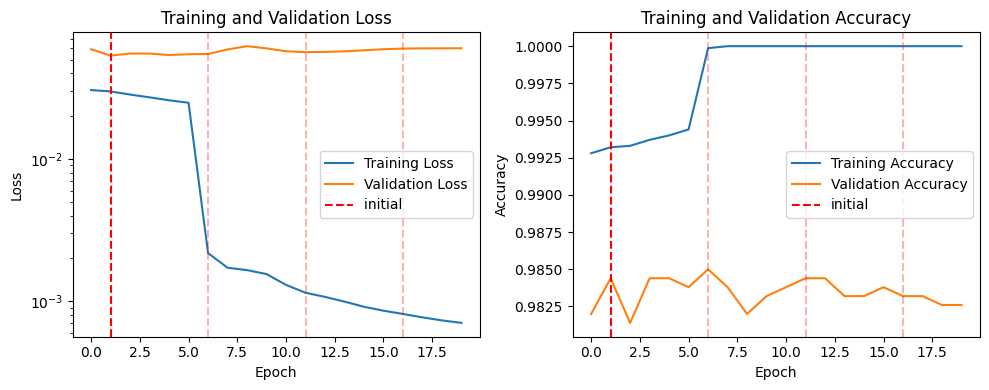

In [16]:
import matplotlib.pyplot as plt

# Graficar la pérdida de entrenamiento y validación
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_info['train_losses'], label='Training Loss')
plt.plot(train_info['val_losses'], label='Validation Loss')
plt.axvline(x=epoch_init_filter, color='r', linestyle='--', label='initial ')
for i in range(epoch_init_filter, epochs + 1, update_period_in_epochs):
    plt.axvline(x=i, color='r', linestyle='--', alpha=0.3)  # Líneas cada 5 epochs
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()

# Graficar la exactitud de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(train_info['train_accuracies'], label='Training Accuracy')
plt.plot(train_info['val_accuracies'], label='Validation Accuracy')
plt.axvline(x=epoch_init_filter, color='r', linestyle='--', label='initial')
for i in range(epoch_init_filter, epochs + 1, update_period_in_epochs):
    plt.axvline(x=i, color='r', linestyle='--', alpha=0.3)  # Líneas cada 5 epochs
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# Cargar mejores pesos
model_mnist.load_weights(checkpoint_filepath)

# Evalaución Accuracy
loss_train, accuracy_train = model_mnist.evaluate(X_tr_filtered, y_tr_filtered, verbose=0)
loss_val, accuracy_val = model_mnist.evaluate(X_val, y_val_encoded, verbose=0)
print(f"Training loss: {loss_train}")
print(f"Training accuracy: {accuracy_train}")
print(f"Validation loss: {loss_val}")
print(f"Validation accuracy: {accuracy_val}")



Training loss: 0.0018245228566229343
Training accuracy: 1.0
Validation loss: 0.054719991981983185
Validation accuracy: 0.9849939942359924


In [21]:
print(all_removed_indices)

[8193, 8196, 8197, 10, 8202, 13, 15, 17, 8209, 22, 23, 25, 26, 8218, 8221, 31, 8225, 34, 8233, 8234, 43, 47, 48, 57, 60, 61, 8254, 8255, 64, 65, 8259, 68, 8260, 8261, 75, 76, 8268, 78, 79, 80, 81, 8272, 8274, 8282, 8285, 94, 98, 99, 8293, 105, 107, 8302, 111, 112, 8303, 115, 116, 8310, 121, 126, 128, 8322, 8327, 137, 8329, 8330, 140, 8333, 142, 8338, 150, 8343, 152, 8347, 8349, 8352, 8353, 163, 8356, 8358, 167, 168, 8359, 170, 171, 8360, 8361, 174, 175, 176, 8362, 8363, 8370, 180, 181, 8373, 8374, 204, 205, 206, 8396, 8402, 8405, 214, 8409, 8411, 222, 224, 225, 8416, 228, 231, 8423, 8424, 8425, 236, 237, 8429, 241, 8433, 248, 8440, 8448, 258, 259, 261, 262, 8460, 8461, 271, 272, 8465, 277, 8470, 8471, 8474, 283, 8477, 287, 8480, 289, 291, 294, 295, 296, 297, 8489, 302, 305, 307, 8500, 311, 312, 315, 321, 8515, 325, 8517, 8518, 8522, 333, 335, 8527, 8528, 338, 8533, 343, 8536, 8539, 8541, 351, 354, 8549, 8550, 361, 8553, 372, 374, 8566, 8567, 8573, 384, 8577, 8581, 8582, 392, 393, 394, 